In [32]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from dnafiber.deployment import run_one_file
from dnafiber.inference import _get_model
import seaborn as sns

from dnafiber.analysis.ratios import load_experiment, normalize_df, create_violin_plot, compare_pairs, graders_statistical_test

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:

root = Path("/home/clement/Documents/data/DNAFiber/Output/YM-2025-20/2025-05-16/")
path_gt = Path("/home/clement/Documents/data/DNAFiber/GT/YM-2025-20.xlsx")
combined_df1 = load_experiment(root, path_gt)
combined_df1["Type"] = combined_df1["Type"].replace({"siT+B2": "siTONSL-D+siBRCA2", "siTONS+b1": "siTONSL-D+siBRCA1"})

root = Path("/home/clement/Documents/data/DNAFiber/Output/YM-2025-16")
path_gt = Path("/home/clement/Documents/data/DNAFiber/GT/YM-2025-16.xlsx")
combined_df2 = load_experiment(root, path_gt)
combined_df2["Type"] = combined_df2["Type"].replace({"sitonsl2-2_25": "siTONSL2 2.25", 
                                                   "sitonsl4_1_125": "siTONSL4 1.125",
                                                   "sitonsl4_15": "siTONSL4 15",
                                                   "sitonsl2-1_125": "siTONSL2 1.125",
                                                   "sitonsl4_2_25": "siTONSL4 2.25",
                                                   "sitonsl2-15": "siTONSL2 15",
                                                   "siTONSL 15": "siTONSL2 15",
                                                   "siTONSL 2.5": "siTONSL2 2.25",})


exp = "YM-2025-17"
root = Path(f"/home/clement/Documents/data/DNAFiber/Output/{exp}")
path_gt = Path(f"/home/clement/Documents/data/DNAFiber/GT/{exp}.xlsx")
combined_df3 = load_experiment(root, path_gt)
combined_df3["Type"] = combined_df3["Type"].replace({"si5+si53": "siTONSL+si53BP1"})

exp = "YM-2025-21-22"
root = Path(f"/home/clement/Documents/data/DNAFiber/Output/{exp}/2025-05-16/")
path_gt = Path(f"/home/clement/Documents/data/DNAFiber/GT/{exp}.xlsx")


combined_df4 = load_experiment(root, [Path("/home/clement/Documents/data/DNAFiber/GT/YM-2025-21.xlsx"), 
                                     Path("/home/clement/Documents/data/DNAFiber/GT/YM-2025-22.xlsx")])
combined_df4["Type"] = combined_df4["Type"].replace({"mms22l ko2": "MMS22L K0-2",
                                                   "mms22l ko1": "MMS22L K0-1",
                                                   "u2os-ctl": "U2OS-CTL",
                                                   "siNT +C5": "siNT+C5",
                                                   "siMMS22L +C5": "siMMS22L+C5"
                                                   })

combined_df = pd.concat([combined_df1, combined_df2, combined_df3, combined_df4], ignore_index=True)
combined_df["Type"] = combined_df["Type"].astype(str)

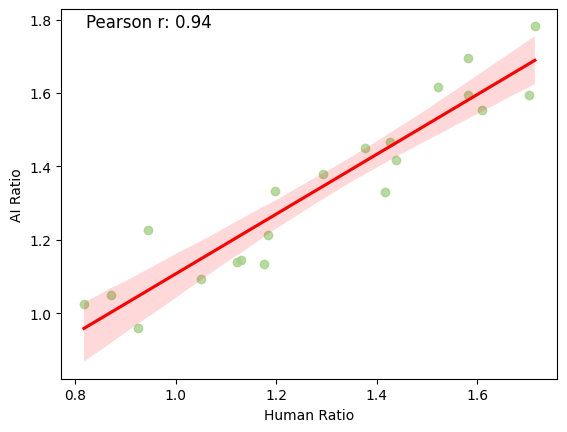

In [ ]:
groupedbyHuman = combined_df[combined_df.Grader == "Human"].groupby("Type")
groupedbyAI = combined_df[combined_df.Grader == "AI"].groupby("Type")

ai_median = groupedbyAI.median(True)
human_median = groupedbyHuman.median(True)

ai_median.columns = [f"AI_{col}" for col in ai_median.columns]
human_median.columns = [f"Human_{col}" for col in human_median.columns]

human_ai = pd.merge(human_median, ai_median, left_on="Type", right_index=True)

human_ai.sort_values("Human_Ratio", inplace=True)
palette = ["#a6d189", "#e78284"]
plt.figure(figsize=(10, 6))
for i, col in enumerate(human_ai.columns):
    plt.plot(human_ai.index, human_ai[col], marker='o', label=col, color=palette[i])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Type")
plt.title("Human vs AI Median Ratios")
plt.legend(loc='upper center', ncol=2)
plt.savefig("output/human_vs_ai_median_ratios.png", dpi=300, bbox_inches='tight')
plt.close()
correlation = human_ai["Human_Ratio"].corr(human_ai["AI_Ratio"])


sns.regplot(data=human_ai, x="Human_Ratio", y="AI_Ratio", marker='o', line_kws={"color": "red"}, color='#a6d189')
plt.text(0.05, 0.95, f"Pearson r: {correlation:.2f}", transform=plt.gca().transAxes, fontsize=12,)
plt.xlabel("Human Ratio")
plt.ylabel("AI Ratio")
plt.savefig("output/human_vs_ai_regression.png", dpi=300, bbox_inches='tight')